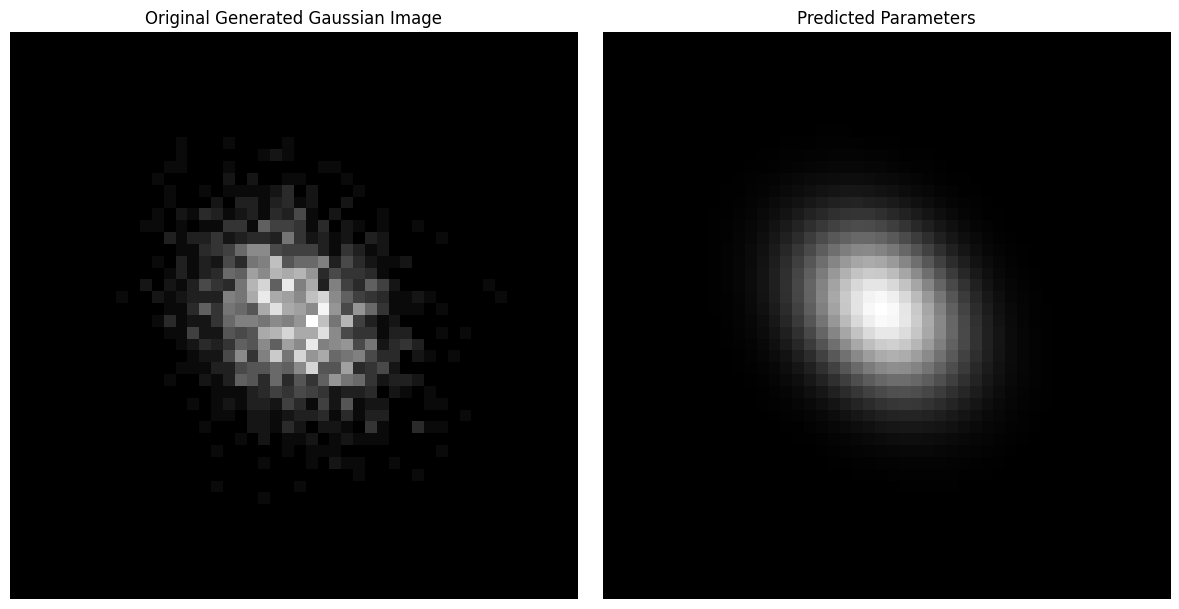

Estimated Mean: [23.046875   23.07161458]
Estimated Covariance Matrix:
[[19.57899004  5.21232096]
 [ 5.21232096 20.78078885]]


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.ndimage import gaussian_filter
import os

def generate_gaussian_image(size, mean, cov):
    """Generate a 2D Gaussian image with noise."""
    num_pixels = size[0] * size[1]
    x = np.random.multivariate_normal(mean, cov, num_pixels)
    x = np.clip(x, 0, size[0] - 1).astype(int)
    image = np.zeros(size, dtype=np.float32)
    for i in range(num_pixels):
        image[x[i, 1], x[i, 0]] += 1
    return image

def generate_ideal_gaussian_image(size, mean, cov):
    """Generate a 2D Gaussian image without noise based on the mean and covariance."""
    x, y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))
    xy = np.column_stack([x.ravel(), y.ravel()])
    
    inv_cov = np.linalg.inv(cov)
    diff = xy - mean
    z = np.exp(-0.5 * np.sum(diff @ inv_cov * diff, axis=1))
    z = z.reshape(size)
    z /= z.max()  # Normalize to the range [0, 1]
    
    return z

def estimate_gaussian_parameters(data, weights):
    """Estimate the mean and covariance matrix of 2D Gaussian data with weights."""

    sigma = 1.0  # Standard deviation for Gaussian kernel
    smoothed_data = gaussian_filter(data, sigma=sigma)

    mean = np.average(smoothed_data, axis=0, weights=weights)
    
    diff = data - mean
    covariance_matrix = np.cov(diff.T, aweights=weights, bias=True)
    
    return mean, covariance_matrix

def plot_covariance_ellipse(mean, cov, ax, color='blue', label=None):
    """Plot an ellipse representing the covariance matrix."""
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    
    # Compute the angle of the ellipse
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
    # Compute the width and height of the ellipse
    width, height = 2 * np.sqrt(eigenvalues)
    
    # Create and add the ellipse patch
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, color=color, alpha=0.5)
    ax.add_patch(ellipse)
    
    if label:
        ax.legend([ellipse], [label])

size = (48, 48)
mean = np.array([24, 24]) 
cov = np.array([[20, 5], [5, 20]]) 

image = generate_gaussian_image(size, mean, cov)

y_coords, x_coords = np.indices(size)
data = np.vstack((x_coords.ravel(), y_coords.ravel())).T
weights = image.ravel()

estimated_mean, estimated_covariance_matrix = estimate_gaussian_parameters(data, weights)
ideal_image = generate_ideal_gaussian_image(size, estimated_mean, estimated_covariance_matrix)

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', origin='upper')
plt.title('Original Generated Gaussian Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ideal_image, cmap='gray', origin='upper')
plt.title('Predicted Parameters')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Estimated Mean:", estimated_mean)
print("Estimated Covariance Matrix:")
print(estimated_covariance_matrix)

In [19]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

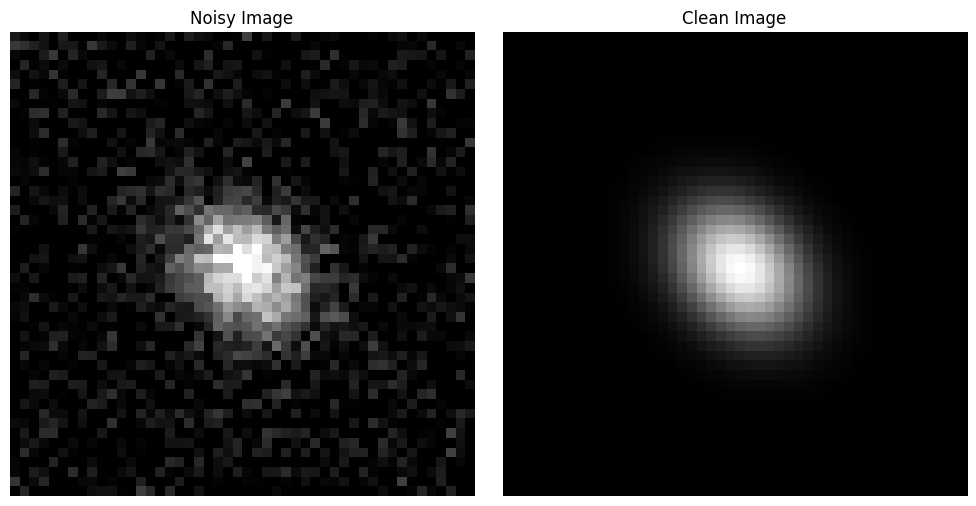

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_ideal_gaussian_image(size, mean, cov):
    """Generate a 2D Gaussian image without noise based on the mean and covariance."""
    x, y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))
    xy = np.column_stack([x.ravel(), y.ravel()])
    
    inv_cov = np.linalg.inv(cov)
    diff = xy - mean
    z = np.exp(-0.5 * np.sum(diff @ inv_cov * diff, axis=1))
    z = z.reshape(size)
    z /= z.max()  # Normalize to the range [0, 1]
    
    return z

def add_noise(image, noise_level):
    """Add Gaussian noise to an image."""
    noisy_image = image + np.random.normal(0, noise_level, image.shape)
    noisy_image = np.clip(noisy_image, 0, 1)  # Ensure pixel values are in [0, 1]
    return noisy_image

def generate_data(num_samples, size, mean, cov, noise_level):
    """Generate noisy and clean image pairs."""
    X = np.zeros((num_samples, size[0], size[1], 1), dtype=np.float32)
    Y = np.zeros((num_samples, size[0], size[1], 1), dtype=np.float32)

    for i in range(num_samples):
        clean_image = generate_ideal_gaussian_image(size, mean, cov)
        noisy_image = add_noise(clean_image, noise_level)
        
        X[i, :, :, 0] = noisy_image
        Y[i, :, :, 0] = clean_image
    
    return X, Y

# Parameters
size = (48, 48)  # Image size
mean = np.array([24, 24])  # Center of the Gaussian distribution
cov = np.array([[20, 5], [5, 20]])  # Covariance matrix
num_samples = 1000  # Number of image pairs
noise_level = 0.1  # Standard deviation of Gaussian noise

# Generate dataset
X, Y = generate_data(num_samples, size, mean, cov, noise_level)

# Split into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Example visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train[0, :, :, 0], cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Y_train[0, :, :, 0], cmap='gray')
plt.title('Clean Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_denoising_cnn(input_shape):
    """Builds a small CNN for image denoising."""
    model = models.Sequential()

    # Input layer
    model.add(layers.InputLayer(shape=input_shape))

    # Convolutional layers
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

    # Additional convolutional layers to capture more features
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

    # Output layer
    model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

# Example usage
input_shape = (48, 48, 1)  # Assuming grayscale images of shape 48x48
denoising_model = build_denoising_cnn(input_shape)
denoising_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 48, 48, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,001 (437.50 KB)

 Trainable params: 112,001 (437.50 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Assume we have two datasets: X_train (noisy images) and Y_train (clean images)
# For example, you could generate X_train using your noisy image generation method,
# and Y_train could be generated using the ideal Gaussian image method.

# Reshape the data to include a channel dimension (grayscale images)
X_train = X_train.reshape(-1, 48, 48, 1)
Y_train = Y_train.reshape(-1, 48, 48, 1)

# Train the model
denoising_model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.1)

# After training, use the model to denoise new images
denoised_images = denoising_model.predict(X_test)

Epoch 1/10


I0000 00:00:1723233581.474870 3717704 service.cc:146] XLA service 0x7f9350004750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723233581.474912 3717704 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1723233581.474916 3717704 service.cc:154]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1723233581.474928 3717704 service.cc:154]   StreamExecutor device (2): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1723233581.474934 3717704 service.cc:154]   StreamExecutor device (3): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1723233581.474938 3717704 service.cc:154]   StreamExecutor device (4): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1723233581.474942 3717704 service.cc:154]   StreamExecutor device (5): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1723233581.474945 3717704 service.cc:154]   StreamExecutor device (6): NVID

16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1658

I0000 00:00:1723233584.820057 3717704 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.1394 - val_loss: 0.0264
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0264 - val_loss: 0.0264
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0264 - val_loss: 0.0264
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0264 - val_loss: 0.0264
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0264 - val_loss: 0.0264
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0264 - val_loss: 0.0264
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0264 - val_loss: 0.0264
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0264 - val_loss: 0.0264
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0264 - val_loss: 0.0264
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0264 - val_loss: 0.0264
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
